### **Import Library**

In [1]:
# ===== Torch Library ===== #
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR, CosineAnnealingLR, ReduceLROnPlateau

import torch.nn as nn
import torch.nn.functional as F

import torchvision 
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

from torcheval.metrics import R2Score

from torchsummary import summary

# ===== etc ===== #
import numpy as np
import pandas as pd

import copy
from copy import deepcopy

import argparse
import matplotlib.pyplot as plt

import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### **Dataset**

In [2]:
def normalize(a):
    return (a-a.min(dim=0)[0])/(a.max(dim=0)[0]-a.min(dim=0)[0])


sleep_dir = './Dataset/user_sleep_2020.csv'


sleep_df = pd.read_csv(sleep_dir)
sleep_df[['startDt', 'endDt', 'lastUpdate']] = sleep_df[['startDt', 'endDt', 'lastUpdate']]/60

sleep_data, sleep_label = sleep_df.iloc[:,3:-1], sleep_df.iloc[:,-1]

sleep_data = normalize(torch.Tensor(sleep_data.values).to(torch.float32))
sleep_label = torch.Tensor(sleep_label.values).to(torch.float32).unsqueeze(1)

rand_idx = torch.randperm(len(sleep_data))

sleep_data, sleep_label = sleep_data[rand_idx], sleep_label[rand_idx]
print(sleep_data.shape, sleep_label.shape)

in_dim, out_dim = sleep_data.shape[1], 1

torch.Size([615, 19]) torch.Size([615, 1])


In [3]:
dataset = torch.utils.data.TensorDataset(sleep_data, sleep_label)

dataset_size = len(dataset)
train_size = int(len(dataset) * 0.8)
val_size = int(dataset_size * 0.1)
test_size = dataset_size - (train_size + val_size)

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

### **Model**

In [4]:
class Net(nn.Module):
    def __init__(self, in_dim, out_dim, hid_dim, n_layer, act, use_bn, use_xavier):
        super(Net, self).__init__()

        self.in_dim = in_dim
        self.out_dim = out_dim
        self.hid_dim = hid_dim
        self.n_layer = n_layer
        self.act = act
        self.use_bn = use_bn
        self.use_xavier = use_xavier


        # ===== Create Linear Layers ===== #
        self.fc1 = nn.Linear(self.in_dim, self.hid_dim)

        self.linears = nn.ModuleList()
        self.bns = nn.ModuleList()
        for i in range(self.n_layer-1):
            self.linears.append(nn.Linear(self.hid_dim, self.hid_dim))
            if self.use_bn: self.bns.append(nn.BatchNorm1d(self.hid_dim))

        self.fc2 = nn.Linear(self.hid_dim, self.out_dim)


        # ====== Create Activation Function ====== #
        if self.act == 'relu': self.act = nn.ReLU()
        elif self.act == 'leakyrelu': self.act = nn.LeakyReLU()
        elif self.act == 'tanh': self.act = nn.Tanh()
        elif self.act == 'sigmoid': self.act = nn.Sigmoid()
        else: raise ValueError('no valid activation function')


        # ====== Create Regularization Layer ======= #
        if self.use_xavier: self.xavier_init()


    def forward(self, x):
        x = self.act(self.fc1(x))
        for i in range(len(self.linears)):
            x = self.act(self.linears[i](x))
            x = self.bns[i](x)
        x = self.fc2(x)
        return x


    def xavier_init(self):
        for linear in self.linears:
            nn.init.xavier_normal_(linear.weight)
            linear.bias.data.fill_(0.01)

test_model = Net(in_dim, out_dim, 183, 3, 'relu', True, True).to(device) # arbitrary hidden_dim
summary(test_model, (in_dim,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 183]           3,660
              ReLU-2                  [-1, 183]               0
            Linear-3                  [-1, 183]          33,672
              ReLU-4                  [-1, 183]               0
       BatchNorm1d-5                  [-1, 183]             366
            Linear-6                  [-1, 183]          33,672
              ReLU-7                  [-1, 183]               0
       BatchNorm1d-8                  [-1, 183]             366
            Linear-9                    [-1, 1]             184
Total params: 71,920
Trainable params: 71,920
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.27
Estimated Total Size (MB): 0.29
---------------------------------------------

### **Training Functions**

In [5]:
def train(model, partition, criterion, optimizer, metric, args): 
    train_loader = DataLoader(partition['train'], batch_size=args.train_batch_size, shuffle=True)

    r_square, total = 0, 0
    train_loss = 0  

    for inputs, labels in iter(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad() 

        for i in range(args.in_dim):
            masking_idx = torch.where(torch.empty(inputs.shape[0], 1).uniform_(0, 1) > args.threshold, 1.0, 0.0).squeeze().to(device)
            inputs[:,i] = masking_idx*inputs[:,i]

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        metric.update(outputs, labels)
        r_square += metric.compute().item()

    train_loss /= len(train_loader)
    train_accuracy = (r_square / len(train_loader)) * 100.0

    return model, train_loss, train_accuracy


def validate(model, partition, criterion, metric, args):
    val_loader = DataLoader(partition['val'], batch_size=args.test_batch_size, shuffle=False)
    model.eval()
        
    r_square, total = 0, 0 # 정답을 맞힌 이미지 개수, 전체 이미지 개수
    loss =  0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        for i in range(args.in_dim):
            masking_idx = torch.where(torch.empty(inputs.shape[0], 1).uniform_(0, 1) > args.threshold, 1.0, 0.0).squeeze().to(device)
            inputs[:,i] = masking_idx*inputs[:,i]

        outputs = model(inputs)
        loss += criterion(outputs, labels).item()
        metric.update(outputs, labels)
        r_square += metric.compute().item()

    val_loss = loss / len(val_loader)
    val_accuracy = (r_square / len(val_loader)) * 100.0
    
    return val_loss, val_accuracy


def test(model, partition, metric, args):
    test_loader = DataLoader(partition['test'], batch_size=args.test_batch_size, shuffle=False)
    model.eval()
        
    r_square, total = 0, 0 # 정답을 맞힌 이미지 개수, 전체 이미지 개수

    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        for i in range(args.in_dim):
            masking_idx = torch.where(torch.empty(inputs.shape[0], 1).uniform_(0, 1) > args.threshold, 1.0, 0.0).squeeze().to(device)
            inputs[:,i] = masking_idx*inputs[:,i]

        outputs = model(inputs)

        metric.update(outputs, labels)
        r_square += metric.compute().item()

    test_accuracy = (r_square / len(test_loader)) * 100.0
    
    return test_accuracy

In [6]:
def experiment(partition, args):
    model = Net(args.in_dim, args.out_dim, args.hid_dim, args.n_layer, args.act, args.use_bn, args.use_xavier).to(device)
    
    criterion = nn.MSELoss()
    metric = R2Score()
    
    if args.optim == 'SGD': optimizer = optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'RMSprop': optimizer = optim.RMSprop(model.parameters(), lr=args.lr, weight_decay=args.l2)
    elif args.optim == 'Adam': optimizer = optim.Adam(model.parameters(), lr=args.lr, weight_decay=args.l2)
    else: raise ValueError('In-valid optimizer choice')

    if args.scheduler == 'ExponentialLR': scheduler = ExponentialLR(optimizer, gamma=0.5)
    elif args.scheduler == 'CosineAnnealingLR': scheduler = CosineAnnealingLR(optimizer, T_max=50, eta_min=0)
    elif args.scheduler == 'ReduceLROnPlateau': scheduler = ReduceLROnPlateau(optimizer, 'min')
    else: raise ValueError('In-valid scheduler choice')
    
    train_losses, train_acces = [], []
    val_losses, val_acces = [], []
    best_set = (0, 0)

    for epoch in range(args.epochs):
        model, train_loss, train_acc = train(model, partition, criterion, optimizer, metric, args)
        val_loss, val_acc = validate(model, partition, criterion, metric, args)

        scheduler.step() if args.scheduler!='ReduceLROnPlateau' else scheduler.step(val_loss)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acces.append(train_acc)
        val_acces.append(val_acc)

        if epoch%1000 == 0 or epoch==(args.epochs-1):
            print(f'[Epoch {epoch}]  Train Loss: {train_loss}  Train Acc: {train_acc:.2f}  Val Loss: {val_loss}  Val Acc: {val_acc:.2f}')

            
        # ===== early stopping ===== #
        if val_acc > best_set[0]: 
            best_set = (val_acc, epoch)
            torch.save(model.state_dict(), f"models/{args.exp_name}/[{args.threshold}, {args.hid_dim}, {args.n_layer}]model.pth")


    test_acc = test(model, partition, metric, args) 
    print(f'Test Acc: {test_acc}')

    return train_losses, val_losses, train_acces, val_acces


In [7]:
def plot_loss(train_losses, val_losses, train_acces, val_acces):
    plt.figure(figsize=(8, 3))
    
    plt.subplot(1,2,1)
    plt.plot(train_losses, label = 'Train')
    plt.plot(val_losses, label = 'Val')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_acces, label = 'Train')
    plt.plot(val_acces, label = 'Val')
    plt.xlabel('Rounds')
    plt.grid()
    plt.legend()

    plt.show()

#### **Experiments**

exp_name: Single modal
lr: 0.01
threshold: 0

[Epoch 0]  Train Loss: 2879.5406799316406  Train Acc: -364.31  Val Loss: 2663.24853515625  Val Acc: -336.01
[Epoch 1000]  Train Loss: 7.421665251255035  Train Acc: 97.58  Val Loss: 27.74238395690918  Val Acc: 97.58
[Epoch 2000]  Train Loss: 7.368233293294907  Train Acc: 98.06  Val Loss: 27.741661071777344  Val Acc: 98.06
[Epoch 3000]  Train Loss: 7.343600034713745  Train Acc: 98.21  Val Loss: 27.741405487060547  Val Acc: 98.21
[Epoch 4000]  Train Loss: 7.351848602294922  Train Acc: 98.29  Val Loss: 27.740928649902344  Val Acc: 98.29
[Epoch 5000]  Train Loss: 7.3910441398620605  Train Acc: 98.34  Val Loss: 27.74061393737793  Val Acc: 98.34
[Epoch 6000]  Train Loss: 7.371120512485504  Train Acc: 98.37  Val Loss: 27.739809036254883  Val Acc: 98.37
[Epoch 7000]  Train Loss: 7.332117140293121  Train Acc: 98.39  Val Loss: 27.739276885986328  Val Acc: 98.39
[Epoch 8000]  Train Loss: 7.422545820474625  Train Acc: 98.41  Val Loss: 27.73845863342285 

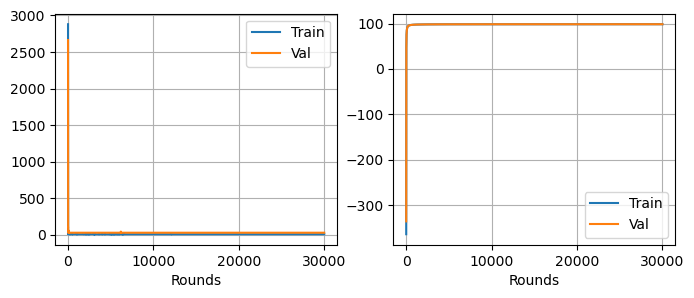

exp_name: ED/Single modal
lr: 0.01
threshold: 0.2

[Epoch 0]  Train Loss: 2961.4437866210938  Train Acc: -365.22  Val Loss: 3065.016357421875  Val Acc: -353.82
[Epoch 1000]  Train Loss: 134.84479427337646  Train Acc: 79.10  Val Loss: 166.72193908691406  Val Acc: 79.10
[Epoch 2000]  Train Loss: 115.08486461639404  Train Acc: 79.67  Val Loss: 110.68797302246094  Val Acc: 79.68
[Epoch 3000]  Train Loss: 136.9710750579834  Train Acc: 79.92  Val Loss: 146.7127227783203  Val Acc: 79.92
[Epoch 4000]  Train Loss: 110.64031600952148  Train Acc: 80.00  Val Loss: 191.25180053710938  Val Acc: 80.00
[Epoch 5000]  Train Loss: 103.63710117340088  Train Acc: 80.06  Val Loss: 192.93992614746094  Val Acc: 80.06
[Epoch 6000]  Train Loss: 128.20126724243164  Train Acc: 80.09  Val Loss: 190.93077087402344  Val Acc: 80.09
[Epoch 7000]  Train Loss: 129.99420928955078  Train Acc: 80.13  Val Loss: 200.08346557617188  Val Acc: 80.13
[Epoch 8000]  Train Loss: 124.36270427703857  Train Acc: 80.15  Val Loss: 153.1

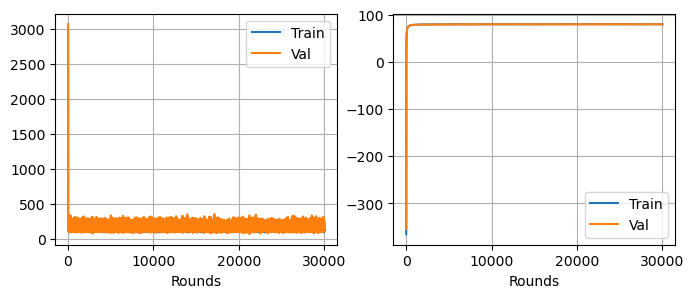

In [8]:
# Train Single modal models (w/ ED & w/o ED)

seed = 1228
np.random.seed(seed)
torch.manual_seed(seed)

parser = argparse.ArgumentParser()
args = parser.parse_args("")
args.exp_name = ''             ######  Variable 1  ######

# ====== Model Capacity ====== #
args.in_dim = in_dim
args.out_dim = out_dim
args.hid_dim = 183
args.act = 'relu'
args.n_layer = 3

# ====== Regularization ======= #
args.use_bn = True
args.l2 = 1e-07
args.use_xavier = True

# ====== Optimizer & Training ====== #
args.optim = 'Adam'
args.scheduler = 'ReduceLROnPlateau'
args.lr = ""          ######  Variable 2  ######

# ====== Training Params ====== #
args.epochs = 30000
args.train_batch_size = 64
args.test_batch_size = 64

args.threshold = 0                  ######  Variable 3  ######

# ===== Name of Hyperparameters to tune ===== #
name_var1 = 'exp_name'
name_var2 = 'lr'
name_var3 = 'threshold'

# ===== Variable of Hyperparameters to tune ===== #
list_var1 = ['Single modal', 'ED/Single modal']
list_var2 = [0.01, 0.01]
list_var3 = [0, 0.2]


# =========================  Experiments  ========================= #
partition = {'train':train_set, 'val':val_set, 'test':test_set}

for var1, var2, var3 in zip(list_var1, list_var2, list_var3):
    setattr(args, name_var1, var1)      # setattr means => args.exp_name = var1
    setattr(args, name_var2, var2)      # setattr means => args.lr = var2
    setattr(args, name_var3, var3)      # setattr means => args.threshold = var3

    print(f"{name_var1}: {var1}")
    print(f"{name_var2}: {var2}")
    print(f"{name_var3}: {var3}\n")

    train_losses, val_losses, train_acces, val_acces = experiment(partition, args)
    plot_loss(train_losses, val_losses, train_acces, val_acces)